# Track Predictions for Typhoon Nanmadol

In this example, we will download HRES T0 data for 17 Sep 2022 from [WeatherBench2](https://weatherbench2.readthedocs.io/) at 0.25 degrees resolution and use this as an initial condition to predict the track [Typhoon Nanmadol](https://en.wikipedia.org/wiki/Typhoon_Nanmadol_(2022)).

Running this notebook requires additional Python packages. You can install these as follows:

```
pip install gcsfs cdsapi zarr matplotlib
```

## Downloading the Data

To begin with, we download the data from [WeatherBench2](https://weatherbench2.readthedocs.io/).

In [1]:
from pathlib import Path

import fsspec
import xarray as xr

# Data will be downloaded here.
download_path = Path("~/downloads")

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# We will download from Google Cloud.
url = "gs://weatherbench2/datasets/hres_t0/2016-2022-6h-1440x721.zarr"
ds = xr.open_zarr(fsspec.get_mapper(url), chunks=None)

# Day to download. This will download all times for that day.
day = "2022-09-17"

# Download the surface-level variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-surface-level.nc").exists():
    surface_vars = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "mean_sea_level_pressure",
    ]
    ds_surf = ds[surface_vars].sel(time=day).compute()
    ds_surf.to_netcdf(str(download_path / f"{day}-surface-level.nc"))
print("Surface-level variables downloaded!")

# Download the atmospheric variables. We write the downloaded data to another file to cache.
if not (download_path / f"{day}-atmospheric.nc").exists():
    atmos_vars = [
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "specific_humidity",
        "geopotential",
    ]
    ds_atmos = ds[atmos_vars].sel(time=day).compute()
    ds_atmos.to_netcdf(str(download_path / f"{day}-atmospheric.nc"))
print("Atmos-level variables downloaded!")

Surface-level variables downloaded!
Atmos-level variables downloaded!


## Downloading Static Variables from ERA5 Data

The static variables are not available in WeatherBench2, so we need to download them from ERA5, just like we did [in the example for ERA5](example_era5.ipynb).
To do so, register an account with the [Climate Data Store](https://cds.climate.copernicus.eu/) and create `$HOME/.cdsapirc` with the following content:

```
url: https://cds.climate.copernicus.eu/api
key: <API key>
```

You can find your API key on your account page.

In order to be able to download ERA5 data, you need to accept the terms of use in the [dataset page](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=download).

In [2]:
from pathlib import Path

import cdsapi

# Data will be downloaded here.
download_path = Path("~/downloads")

c = cdsapi.Client()

download_path = download_path.expanduser()
download_path.mkdir(parents=True, exist_ok=True)

# Download the static variables.
if not (download_path / "static.nc").exists():
    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": [
                "geopotential",
                "land_sea_mask",
                "soil_type",
            ],
            "year": "2023",
            "month": "01",
            "day": "01",
            "time": "00:00",
            "format": "netcdf",
        },
        str(download_path / "static.nc"),
    )
print("Static variables downloaded!")

2025-05-08 10:03:42,563 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-08 10:03:42,564 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Static variables downloaded!


## Preparing a Batch

We convert the downloaded data to an `aurora.Batch`, which is what the model requires.

In [3]:
import numpy as np
import torch
import xarray as xr

from aurora import Batch, Metadata

static_vars_ds = xr.open_dataset(download_path / "static.nc", engine="netcdf4")
surf_vars_ds = xr.open_dataset(download_path / f"{day}-surface-level.nc", engine="netcdf4")
atmos_vars_ds = xr.open_dataset(download_path / f"{day}-atmospheric.nc", engine="netcdf4")


def _prepare(x: np.ndarray) -> torch.Tensor:
    """Prepare a variable.

    This does the following things:
    * Select time points two and three: hours 06:00 and 12:00.
    * Insert an empty batch dimension with `[None]`.
    * Flip along the latitude axis to ensure that the latitudes are decreasing.
    * Copy the data, because the data must be contiguous when converting to PyTorch.
    * Convert to PyTorch.
    """
    return torch.from_numpy(x[[1, 2]][None][..., ::-1, :].copy())


batch = Batch(
    surf_vars={
        "2t": _prepare(surf_vars_ds["2m_temperature"].values),
        "10u": _prepare(surf_vars_ds["10m_u_component_of_wind"].values),
        "10v": _prepare(surf_vars_ds["10m_v_component_of_wind"].values),
        "msl": _prepare(surf_vars_ds["mean_sea_level_pressure"].values),
    },
    static_vars={
        # The static variables are constant, so we just get them for the first time. They
        # don't need to be flipped along the latitude dimension, because they are from
        # ERA5.
        "z": torch.from_numpy(static_vars_ds["z"].values[0]),
        "slt": torch.from_numpy(static_vars_ds["slt"].values[0]),
        "lsm": torch.from_numpy(static_vars_ds["lsm"].values[0]),
    },
    atmos_vars={
        "t": _prepare(atmos_vars_ds["temperature"].values),
        "u": _prepare(atmos_vars_ds["u_component_of_wind"].values),
        "v": _prepare(atmos_vars_ds["v_component_of_wind"].values),
        "q": _prepare(atmos_vars_ds["specific_humidity"].values),
        "z": _prepare(atmos_vars_ds["geopotential"].values),
    },
    metadata=Metadata(
        # Flip the latitudes! We need to copy because converting to PyTorch, because the
        # data must be contiguous.
        lat=torch.from_numpy(surf_vars_ds.latitude.values[::-1].copy()),
        lon=torch.from_numpy(surf_vars_ds.longitude.values),
        # Converting to `datetime64[s]` ensures that the output of `tolist()` gives
        # `datetime.datetime`s. Note that this needs to be a tuple of length one:
        # one value for every batch element. Select the third time point.
        time=(surf_vars_ds.time.values.astype("datetime64[s]").tolist()[2],),
        atmos_levels=tuple(int(level) for level in atmos_vars_ds.level.values),
    ),
)

/home/wbruinsma/miniforge3/envs/aurora/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and Running the Model

Finally, we are ready to load and run the model and visualise the predictions. We perform a roll-out for eight steps, which produces predictions for up to two days into the future.

In [4]:
from datetime import datetime

from aurora import Aurora, Tracker, rollout

model = Aurora()
model.load_checkpoint("microsoft/aurora", "aurora-0.25-finetuned.ckpt")

# Initialise the tracker with the position of Nanmadol at 17 Sept 2022 at UTC 12. Taken from
# IBTrACS: https://ncics.org/ibtracs/index.php?name=v04r01-2022254N24143
tracker = Tracker(init_lat=27.50, init_lon=132, init_time=datetime(2022, 9, 17, 12, 0))

model.eval()
model = model.to("cuda")

preds = []
with torch.inference_mode():
    for pred in rollout(model, batch, steps=8):
        pred = pred.to("cpu")  # Immediately free up the GPU.
        preds.append(pred)
        tracker.step(pred)

model = model.to("cpu")

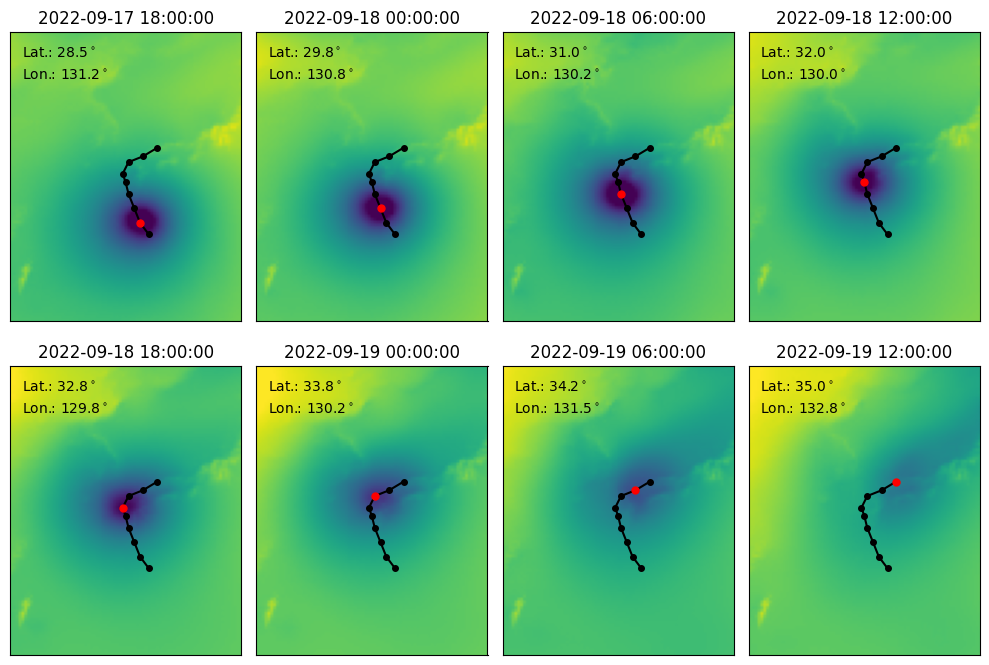

In [10]:
import matplotlib.pyplot as plt

track = tracker.results()

fig, axs = plt.subplots(2, 4, figsize=(10, 7))

for i in range(8):
    pred = preds[i]
    ax = axs[i // 4, i % 4]

    # Cut a square around Nanmadol.
    lat_mask = (pred.metadata.lat >= 20) & (pred.metadata.lat <= 45)
    lon_mask = (pred.metadata.lon >= 120) & (pred.metadata.lon <= 140)

    # Show the forecast for MSL.
    ax.imshow(
        pred.surf_vars["msl"][0, 0][lat_mask][:, lon_mask].numpy() / 100,
        vmin=970,
        vmax=1020,
        extent=(120, 140, 20, 45),
    )
    ax.set_title(str(pred.metadata.time[0]))
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot the whole track for Typhoon Nanmadol.
    ax.plot(track.lon, track.lat, c="k", marker=".", markersize=8)

    # Highlight the current step and also display it on the top left.
    this_step = track[track.time == pred.metadata.time[0]]
    ax.plot(this_step.lon, this_step.lat, c="r", marker=".", markersize=10)
    ax.text(
        0.05,
        0.95,
        f"Lat.: {this_step.lat.iloc[0]:.1f}${{}}^\\circ$",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )
    ax.text(
        0.05,
        0.875,
        f"Lon.: {this_step.lon.iloc[0]:.1f}${{}}^\\circ$",
        ha="left",
        va="top",
        transform=ax.transAxes,
    )

plt.tight_layout()